In [ ]:
!pip install emoji==1.7.0 sentence_transformers gensim pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.9 MB/s eta 0:00:00


# Read data

Only using 20% of the dataset for performance reasons.

In [ ]:
import pandas as pd
import numpy as np

# File path
file_path = '/content/drive/MyDrive/Colab Notebooks/Twitter_Jan_Mar.csv'

# Function to determine which rows to skip
def skip_rows(row_idx):
    if row_idx == 0:
        return False
    return np.random.rand() > 0.20  # Skip rows with an 80% chance

# Try to read the CSV file with skiprows
try:
    df = pd.read_csv(file_path, skiprows=lambda x: skip_rows(x), on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"Encountered a parsing error: {e}")
    print("Attempting to load the data without problematic rows using on_bad_lines='skip'")
    df = pd.read_csv(file_path, skiprows=lambda x: skip_rows(x), on_bad_lines='skip')

print(df.head())

                        date                   id  \
0  2023-03-29 22:57:52+00:00  1641213110915571715   
1  2023-03-29 22:57:26+00:00  1641213003260633088   
2  2023-03-29 22:56:48+00:00  1641212842828533761   
3  2023-03-29 22:54:46+00:00  1641212328900284418   
4  2023-03-29 22:54:16+00:00  1641212202593193984   

                                             content         username  \
0  AI muses: "In the court of life, we must all f...   ChatGPT_Thinks   
1  Most people haven't heard of Chat GPT yet.\nFi...    nikocosmonaut   
2  Anyone familiar with The "cave allegory"? In t...  ashleighgrente2   
3  You know what a good feature be in ChatGPT @Op...        a_hafez12   
4  #BCM325 I asked #ChatGPT how The Matrix (1999)...       andreamrra   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         1.0            0.0  
4         0.0            0.0  


Pre processing

In [ ]:
from nltk.corpus import stopwords
import nltk
import gensim
import gensim.downloader as api

# Load the GloVe model
glove_model = api.load("glove-wiki-gigaword-300")

# Function to get similar words using the GloVe model
def get_similar_words(lst_words, top, nlp):
    lst_out = set(lst_words)
    for word in lst_words:
        try:
            similar_words = nlp.most_similar(word, topn=top)
            lst_out.update([tup[0] for tup in similar_words])
        except KeyError:  # Word not in vocabulary
            continue
    return list(lst_out)


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[==================================================] 100.0% 376.1/376.1MB downloaded


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import emoji
import re



def utils_clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to string in case it's not
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove emojis
    text = emoji.get_emoji_regexp().sub(u'', text)
    # Remove hashtags and mentions
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove any non-alphanumeric characters (except space)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

# Define the text preprocessing function
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=True, lst_stopwords=None):

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (if chosen)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatization (if chosen)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

# Data Preperation

- Removing stop words
- Removing Emojis
- Tokenize
- Removing words related to chat gpt and open ai as the focus of this task is to find additional topics. Isolating these words will allow the other topics to be more prevelant in the analysis.


In [ ]:
df['cleaned_text'] = df['content'].astype(str).apply(utils_clean_text)

# Load stopwords
stop_words = set(stopwords.words('english'))

# Extend stopwords with terms related to ChatGPT and AI
core_terms = ['ai', 'gpt', 'openai', 'chatgpt', 'chatbot']
extended_stop_words = get_similar_words(core_terms, top=15, nlp=glove_model)
stop_words.update(extended_stop_words)
stop_words.update(['chat', 'amp'])

# Apply pre process function
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stop_words))

df.head()

<ipython-input-4-f1189b063aab>:14: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  text = emoji.get_emoji_regexp().sub(u'', text)


,date,id,content,username,like_count,retweet_count,cleaned_text
0,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0,mus court life must face judge destiny jury ac...
1,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0,people havent heard yet first elite faction de...
2,2023-03-29 22:56:48+00:00,1641212842828533761,"Anyone familiar with The ""cave allegory""? In t...",ashleighgrente2,0.0,0.0,anyone familiar cave allegory allegory plato d...
3,2023-03-29 22:54:46+00:00,1641212328900284418,You know what a good feature be in ChatGPT @Op...,a_hafez12,1.0,0.0,know good feature sharing link conversation ma...
4,2023-03-29 22:54:16+00:00,1641212202593193984,#BCM325 I asked #ChatGPT how The Matrix (1999)...,andreamrra,0.0,0.0,asked matrix us operational research short mac...


Import libraries


In [ ]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import LdaMulticore

# Topic Modelling with LDA

- Use LdaMulticore for performance
- Assign topics to each tweet
- Calculates the percentage of tweets in the dataset that belong to each topic.


In [30]:
# Prepare texts and dictionary as before
texts = [text.split() for text in df['cleaned_text']]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Prepare Corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Use LdaMulticore
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, random_state=100,
                         chunksize=2000, passes=2, workers=4)
# Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Assign topics to each tweet
df['topic'] = [max(lda_model[dictionary.doc2bow(text)], key=lambda x: x[1])[0] for text in texts]

# Analyze the distribution of topics
topic_counts = df['topic'].value_counts(normalize=True) * 100
print(topic_counts)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.010*"use" + 0.010*"technology" + 0.009*"human" + 0.009*"need" + 0.009*"like"')
(1, '0.016*"like" + 0.010*"use" + 0.008*"model" + 0.008*"language" + 0.008*"new"')
(2, '0.008*"using" + 0.008*"future" + 0.008*"model" + 0.008*"content" + 0.008*"tool"')
(3, '0.012*"write" + 0.011*"know" + 0.010*"answer" + 0.010*"asked" + 0.009*"use"')
(4, '0.019*"google" + 0.011*"search" + 0.011*"im" + 0.010*"new" + 0.010*"using"')
topic
1    24.003559
3    22.684071
4    19.919719
0    17.356575
2    16.036076
Name: proportion, dtype: float64


## Plotting the topics

Visualizes the distribution of topics extracted from a dataset using (LDA) by employing t-SNE (t-distributed Stochastic Neighbor Embedding) for dimensionality reduction.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 0.007211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.276134
[t-SNE] KL divergence after 850 iterations: 0.774999


<ipython-input-22-6c9f055f9e9f>:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_coords, y_coords, c='blue', s=sizes, cmap='viridis')


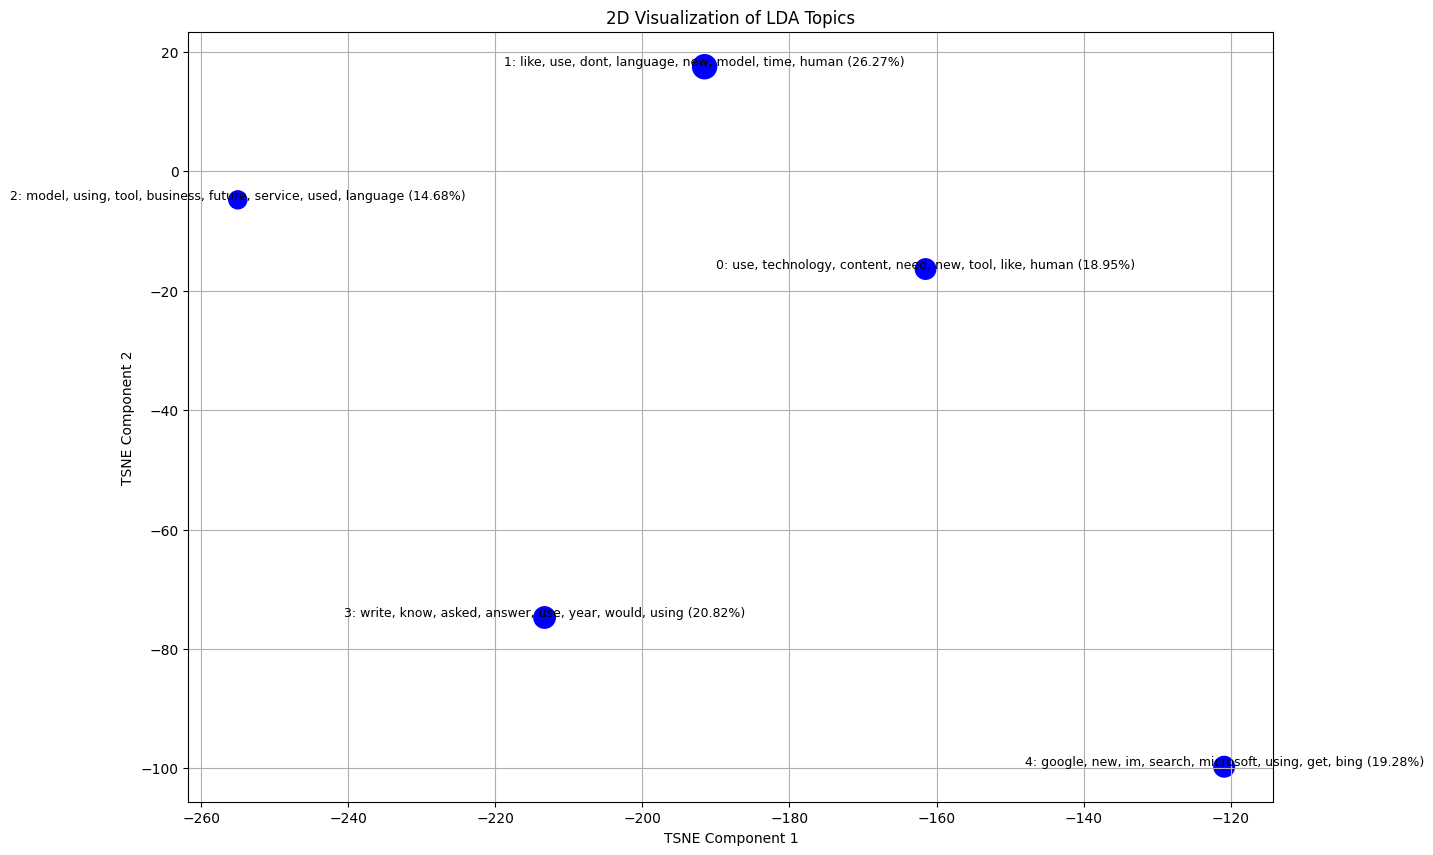

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


topic_terms = lda_model.get_topics()
num_topics = len(topic_terms)


sizes = [300 * (topic_counts[i]/max(topic_counts)) for i in range(num_topics)]


topic_labels = [
    '0: use, technology, content, need, new, tool, like, human ({:.2f}%)'.format(topic_counts[0]),
    '1: like, use, dont, language, new, model, time, human ({:.2f}%)'.format(topic_counts[1]),
    '2: model, using, tool, business, future, service, used, language ({:.2f}%)'.format(topic_counts[2]),
    '3: write, know, asked, answer, use, year, would, using ({:.2f}%)'.format(topic_counts[3]),
    '4: google, new, im, search, microsoft, using, get, bing ({:.2f}%)'.format(topic_counts[4])
]

# TSNE for dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=max(num_topics/3, 1), verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(topic_terms)

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
x_coords = tsne_lda[:, 0]
y_coords = tsne_lda[:, 1]
scatter = ax.scatter(x_coords, y_coords, c='blue', s=sizes, cmap='viridis')

# Annotating the points with topic labels and percentages
for i, txt in enumerate(topic_labels):
    ax.annotate(txt, (x_coords[i], y_coords[i] + 0.15), ha='center', fontsize=9)

plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Visualization of LDA Topics")
plt.grid(True)
plt.show()


## More in depth visualisation

 Uses pyLDAvis library,  for interactive visualization of topics modeled through (LDA)

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA with weights

In [31]:

df.dropna(subset=['cleaned_text'], inplace=True)
df = df[df['cleaned_text'].str.strip().astype(bool)]


df['like_count'].fillna(0, inplace=True)
df['retweet_count'].fillna(0, inplace=True)

# Calculate weights ensuring they're all positive and non-zero
df['weight'] = df['like_count'] + df['retweet_count'] + 1


texts = [text.split() for text in df['cleaned_text'] if text.strip()]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a corpus ensuring there are no zero-length documents
corpus = [dictionary.doc2bow(text) for text in texts if text]
weighted_corpus = [[(id, freq * df.iloc[i]['weight']) for id, freq in doc] for i, doc in enumerate(corpus) if doc]

# Check if the weighted_corpus is empty and proceed with LDA modeling
if not weighted_corpus:
    print("All documents are empty after filtering")
else:
    lda_model = LdaMulticore(corpus=weighted_corpus, id2word=dictionary, num_topics=5, random_state=100, chunksize=2000, passes=2, workers=4)

    # Print the topics found by LDA model
    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(topic)

    df['topic'] = [max(lda_model[dictionary.doc2bow(text)], key=lambda x: x[1])[0] if text and dictionary.doc2bow(text) else None for text in texts]


    try:
        topic_counts = df['topic'].value_counts(normalize=True) * 100
        print(topic_counts)
    except Exception as e:
        print("Error calculating topic counts:", str(e))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.083*"tool" + 0.057*"need" + 0.056*"know" + 0.054*"best" + 0.051*"thesaurus" + 0.036*"answer" + 0.030*"research" + 0.028*"content" + 0.028*"check" + 0.028*"power"')
(1, '0.019*"using" + 0.017*"learn" + 0.011*"token" + 0.010*"browsing" + 0.010*"release" + 0.009*"game" + 0.008*"next" + 0.007*"comment" + 0.007*"day" + 0.007*"tag"')
(2, '0.031*"made" + 0.027*"first" + 0.018*"pause" + 0.011*"asked" + 0.010*"use" + 0.010*"write" + 0.006*"make" + 0.006*"hesitant" + 0.006*"new" + 0.005*"student"')
(3, '0.020*"source" + 0.020*"model" + 0.014*"deck" + 0.011*"slide" + 0.011*"educator" + 0.010*"open" + 0.009*"video" + 0.009*"human" + 0.009*"already" + 0.008*"image"')
(4, '0.016*"like" + 0.013*"new" + 0.011*"google" + 0.010*"im" + 0.008*"asked" + 0.007*"use" + 0.007*"build" + 0.007*"prompt" + 0.006*"think" + 0.006*"work"')
topic
4.0    41.678609
2.0    31.568944
1.0    15.236150
3.0    10.039536
0.0     1.476761
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.001s...
[t-SNE] Computed neighbors for 5 samples in 0.609s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 0.007998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.201611
[t-SNE] KL divergence after 750 iterations: 0.180945


<ipython-input-32-89dc0b7d9672>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_coords, y_coords, c='blue', s=sizes, cmap='viridis')


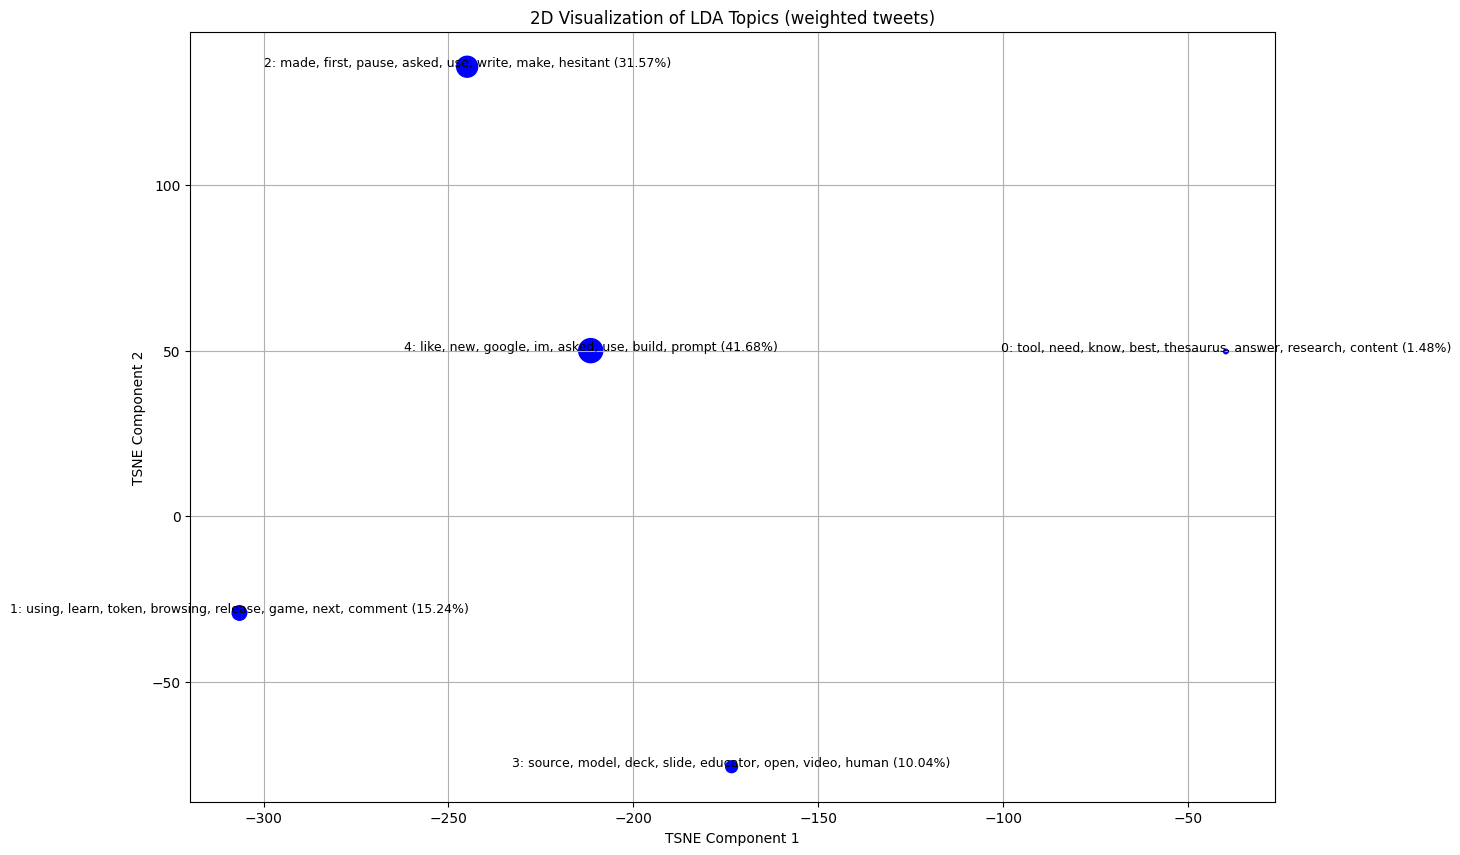

In [32]:

topic_terms = lda_model.get_topics()
num_topics = len(topic_terms)

# Calculate proportions for the sizes of the plot points
sizes = [300 * (topic_counts[i]/max(topic_counts)) for i in range(num_topics)]

# Generate new topic labels from the LDA output
topic_labels = [
    '0: tool, need, know, best, thesaurus, answer, research, content ({:.2f}%)'.format(topic_counts[0]),
    '1: using, learn, token, browsing, release, game, next, comment ({:.2f}%)'.format(topic_counts[1]),
    '2: made, first, pause, asked, use, write, make, hesitant ({:.2f}%)'.format(topic_counts[2]),
    '3: source, model, deck, slide, educator, open, video, human ({:.2f}%)'.format(topic_counts[3]),
    '4: like, new, google, im, asked, use, build, prompt ({:.2f}%)'.format(topic_counts[4])
]

# TSNE for dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=max(num_topics/3, 1), verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(topic_terms)

# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
x_coords = tsne_lda[:, 0]
y_coords = tsne_lda[:, 1]
scatter = ax.scatter(x_coords, y_coords, c='blue', s=sizes, cmap='viridis')

# Annotating the points with topic labels and percentages
for i, txt in enumerate(topic_labels):
    ax.annotate(txt, (x_coords[i], y_coords[i] + 0.15), ha='center', fontsize=9)

plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Visualization of LDA Topics (weighted tweets)")
plt.grid(True)
plt.show()